Imports and Setup

In [15]:
import numpy as np
import time
import gymnasium as gym
import pygame
import matplotlib.pyplot as plt
import os
from collections import deque

# Set up environment variables for rendering
os.environ['SDL_VIDEODRIVER'] = 'windib' if os.name == 'nt' else 'dummy'
pygame.init()

(5, 0)

Environment Initialization and Info

In [20]:
def initialize_environment(render_mode='human'):
    """Initialize environment with specified render mode"""
    try:
        env = gym.make('Taxi-v3', render_mode=render_mode)
        print(f"Successfully initialized with render_mode={render_mode}")
        return env
    except Exception as e:
        print(f"Error initializing environment: {str(e)}")
        return None

def print_env_info(env):
    """Print detailed environment information"""
    print("\n" + "="*50)
    print("ENVIRONMENT INFORMATION")
    print("="*50)
    
    print(f"\nState Space Size: {env.observation_space.n}")
    print("Action Space Size:", env.action_space.n)
    print("Action Mapping: 0=South, 1=North, 2=East, 3=West, 4=Pickup, 5=Dropoff")
    print("="*50 + "\n")

Evaluation Function

In [23]:
def calculate_value_accuracy(q_table, test_episodes=100):
    """Calculate value function accuracy by testing the policy"""
    test_env = initialize_environment(render_mode=None)
    if test_env is None:
        return 0.0
    
    total_reward = 0
    for _ in range(test_episodes):
        state, _ = test_env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action = np.argmax(q_table[state])
            state, reward, terminated, truncated, _ = test_env.step(action)
            done = terminated or truncated
            episode_reward += reward
        
        total_reward += episode_reward
    
    test_env.close()
    average_reward = total_reward / test_episodes
    accuracy = (average_reward + 10) / 30  # Normalize to 0-1 scale
    return max(0, min(1, accuracy))  # Clip to [0,1]

Training the Agent

In [26]:
def train_agent(episodes=10000):
    """Training phase with Q-learning and value accuracy tracking"""
    env = initialize_environment(render_mode=None)
    if env is None:
        return None, [], []
    
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    
    learning_rate = 0.1
    gamma = 0.95
    epsilon = 0.1
    deltas = []
    accuracies = []
    test_frequency = 500
    
    best_accuracy = -np.inf
    best_q_table = None
    
    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        done = False
        episode_delta = 0
        
        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            
            new_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            best_next_action = np.argmax(q_table[new_state])
            td_target = reward + gamma * q_table[new_state][best_next_action]
            td_error = td_target - q_table[state][action]
            q_table[state][action] += learning_rate * td_error
            episode_delta = max(episode_delta, abs(td_error))
            
            state = new_state
        
        deltas.append(episode_delta)
        
        if episode % test_frequency == 0:
            accuracy = calculate_value_accuracy(q_table)
            accuracies.append(accuracy)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_q_table = q_table.copy()
            
            print(f"Episode {episode}, Max Delta: {episode_delta:.4f}, Value Accuracy: {accuracy:.2%}")
        
        if len(deltas) > 100 and np.mean(deltas[-100:]) < 0.0001:
            print(f"Early stopping at episode {episode}")
            break
    
    env.close()
    
    if best_q_table is not None:
        print(f"\nBest value accuracy achieved: {best_accuracy:.2%}")
        return best_q_table, deltas, accuracies
    else:
        return q_table, deltas, accuracies

Visualization Functions

In [29]:
def visualize_results(deltas, accuracies, test_frequency=500):
    """Visualize training progress and value accuracy"""
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(deltas)
    plt.title("Training Progress (Q-learning)")
    plt.xlabel("Episode")
    plt.ylabel("Max Q-value Change")
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    episodes = [i * test_frequency for i in range(1, len(accuracies) + 1)]
    plt.plot(episodes, accuracies, 'r-')
    plt.title("Value Function Accuracy")
    plt.xlabel("Episode")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def visualize_agent(q_table, num_episodes=3):
    """Visualize trained agent's performance"""
    env = initialize_environment(render_mode='human')
    if env is None:
        return
    
    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        done = False
        total_reward = 0
        steps = 0
        
        print(f"\n=== Episode {episode} ===")
        
        while not done and steps < 200:
            env.render()
            action = np.argmax(q_table[state])
            new_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            
            decoded = list(env.unwrapped.decode(state))
            print(f"Step {steps}: Action={['South','North','East','West','Pickup','Dropoff'][action]}")
            print(f"State: Taxi at ({decoded[0]},{decoded[1]}), Passenger at {['R','G','Y','B','In Taxi'][decoded[2]]}, Dest: {['R','G','Y','B'][decoded[3]]}")
            print(f"Reward: {reward}, Total Reward: {total_reward}")
            
            total_reward += reward
            state = new_state
            steps += 1
            time.sleep(0.3)
            
        print(f"Episode finished after {steps} steps, Total reward: {total_reward}")
        time.sleep(1)
    
    env.close()

In [31]:
def main():
    env = initialize_environment()
    if env is None:
        return
    
    print_env_info(env)
    env.close()
    
    print("\nTraining with Q-learning...")
    q_table, deltas, accuracies = train_agent(episodes=30000)
    
    if q_table is not None:
        print("\nVisualizing trained agent...")
        visualize_agent(q_table, num_episodes=3)
        visualize_results(deltas, accuracies)
    
    np.save("taxi_q_learning.npy", q_table)
    print("\nQ-table saved to 'taxi_q_learning.npy'")

Successfully initialized with render_mode=human

ENVIRONMENT INFORMATION

State Space Size: 500
Action Space Size: 6
Action Mapping: 0=South, 1=North, 2=East, 3=West, 4=Pickup, 5=Dropoff


Training with Q-learning...
Successfully initialized with render_mode=None
Successfully initialized with render_mode=None
Episode 500, Max Delta: 8.5270, Value Accuracy: 0.00%
Successfully initialized with render_mode=None
Episode 1000, Max Delta: 6.6568, Value Accuracy: 0.00%
Successfully initialized with render_mode=None
Episode 1500, Max Delta: 8.4380, Value Accuracy: 0.00%
Successfully initialized with render_mode=None
Episode 2000, Max Delta: 6.2006, Value Accuracy: 0.00%
Successfully initialized with render_mode=None
Episode 2500, Max Delta: 7.5838, Value Accuracy: 4.70%
Successfully initialized with render_mode=None
Episode 3000, Max Delta: 0.0971, Value Accuracy: 46.03%
Successfully initialized with render_mode=None
Episode 3500, Max Delta: 2.6656, Value Accuracy: 59.30%
Successfully initiali

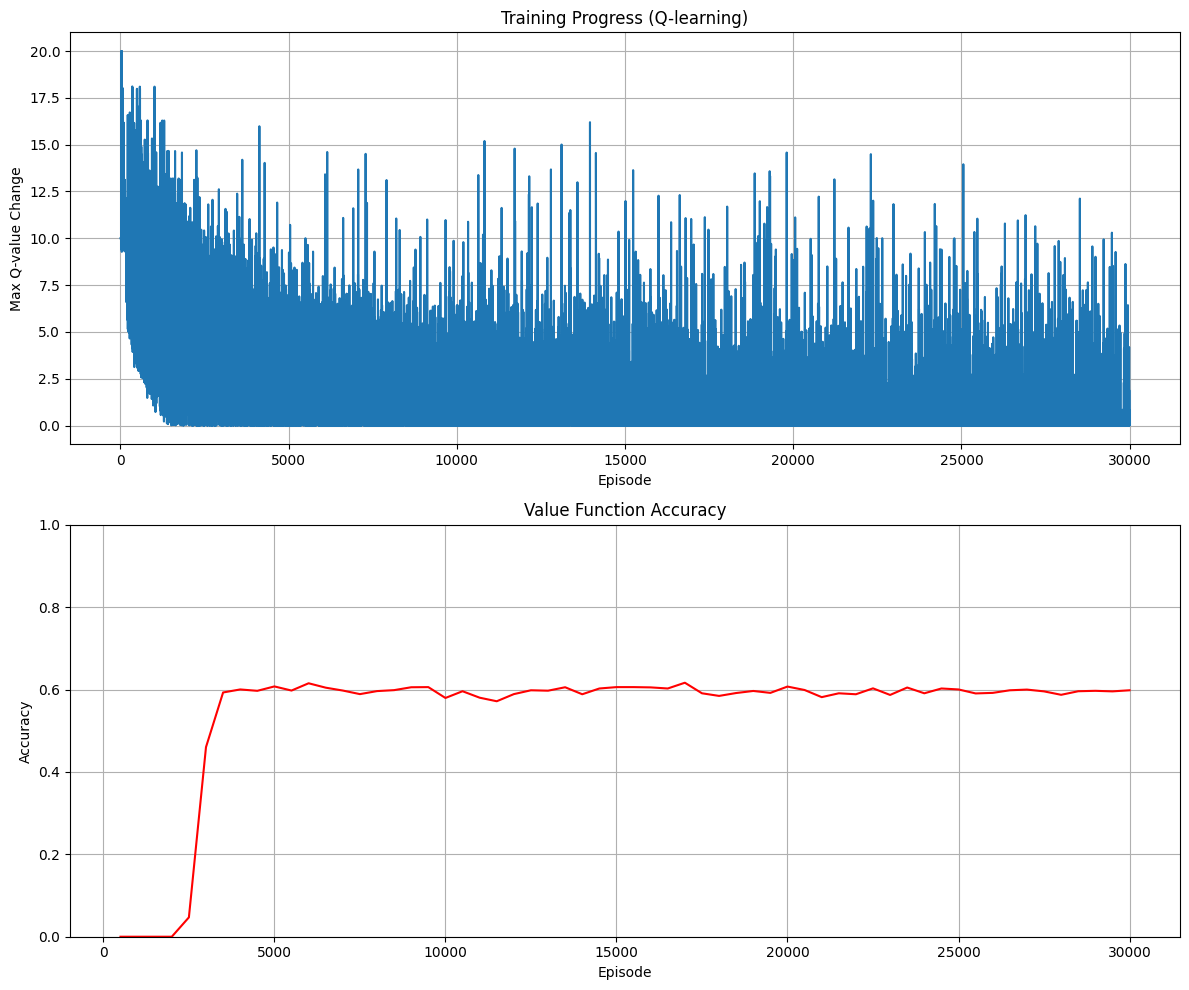


Q-table saved to 'taxi_q_learning.npy'


In [33]:
if __name__ == '__main__':
    try:
        main()
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    finally:
        pygame.quit()